In [256]:
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import time

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from tqdm import tqdm

In [301]:
# Journal impact factors: Source: https://www.scimagojr.com/journalrank.php
j_list = pd.read_csv('scimagojr 2022.csv', sep=';')
j_list.head()

,Rank,Sourceid,Title,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2022),Total Docs. (3years),...,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Region,Publisher,Coverage,Categories,Areas
0,1,28773,Ca-A Cancer Journal for Clinicians,journal,"15424863, 00079235","86,091",Q1,198,44,118,...,30318,85,"299,99","97,00",United States,Northern America,Wiley-Blackwell,1950-2022,Hematology (Q1); Oncology (Q1),Medicine
1,2,29431,Quarterly Journal of Economics,journal,"00335533, 15314650","36,730",Q1,292,36,122,...,2141,122,"14,83","66,61",United Kingdom,Western Europe,Oxford University Press,1886-2022,Economics and Econometrics (Q1),"Economics, Econometrics and Finance"
2,3,20315,Nature Reviews Molecular Cell Biology,journal,"14710072, 14710080","34,201",Q1,485,121,328,...,13331,156,"35,47","89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology"
3,4,18434,Cell,journal,"00928674, 10974172","26,494",Q1,856,420,1637,...,67791,1440,"43,80","65,74",United States,Northern America,Cell Press,1974-2022,"Biochemistry, Genetics and Molecular Biology (...","Biochemistry, Genetics and Molecular Biology"
4,5,15847,New England Journal of Medicine,journal,"00284793, 15334406","26,015",Q1,1130,1410,4561,...,133956,1854,"33,93","10,21",United States,Northern America,Massachussetts Medical Society,1945-2022,Medicine (miscellaneous) (Q1),Medicine


In [302]:
j_list

,Rank,Sourceid,Title,Type,Issn,SJR,SJR Best Quartile,H index,Total Docs. (2022),Total Docs. (3years),...,Total Cites (3years),Citable Docs. (3years),Cites / Doc. (2years),Ref. / Doc.,Country,Region,Publisher,Coverage,Categories,Areas
0,1,28773,Ca-A Cancer Journal for Clinicians,journal,"15424863, 00079235","86,091",Q1,198,44,118,...,30318,85,"299,99","97,00",United States,Northern America,Wiley-Blackwell,1950-2022,Hematology (Q1); Oncology (Q1),Medicine
1,2,29431,Quarterly Journal of Economics,journal,"00335533, 15314650","36,730",Q1,292,36,122,...,2141,122,"14,83","66,61",United Kingdom,Western Europe,Oxford University Press,1886-2022,Economics and Econometrics (Q1),"Economics, Econometrics and Finance"
2,3,20315,Nature Reviews Molecular Cell Biology,journal,"14710072, 14710080","34,201",Q1,485,121,328,...,13331,156,"35,47","89,29",United Kingdom,Western Europe,Nature Publishing Group,2000-2022,Cell Biology (Q1); Molecular Biology (Q1),"Biochemistry, Genetics and Molecular Biology"
3,4,18434,Cell,journal,"00928674, 10974172","26,494",Q1,856,420,1637,...,67791,1440,"43,80","65,74",United States,Northern America,Cell Press,1974-2022,"Biochemistry, Genetics and Molecular Biology (...","Biochemistry, Genetics and Molecular Biology"
4,5,15847,New England Journal of Medicine,journal,"00284793, 15334406","26,015",Q1,1130,1410,4561,...,133956,1854,"33,93","10,21",United States,Northern America,Massachussetts Medical Society,1945-2022,Medicine (miscellaneous) (Q1),Medicine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27950,27951,21101091736,Worldwide Waste,journal,23997117,NaN,-,1,5,0,...,0,0,"0,00","64,00",United Kingdom,Western Europe,Web Portal Ubiquity Press,2022,Waste Management and Disposal,Environmental Science
27951,27952,17700156005,WSEAS Transactions on Heat and Mass Transfer (...,journal,17905044,NaN,-,10,24,0,...,0,0,"0,00","24,71",Greece,Western Europe,World Scientific and Engineering Academy and S...,"2009-2015, 2022",Condensed Matter Physics; Energy (miscellaneou...,Energy; Engineering; Physics and Astronomy
27952,27953,21100829466,Yearbook of Comparative Literature,journal,"19255772, 19255764",NaN,-,4,9,0,...,0,0,"0,00","45,78",Canada,Northern America,University of Toronto Press,"2009-2011, 2013-2017",Cultural Studies; History; Literature and Lite...,Arts and Humanities; Social Sciences
27953,27954,21100212328,Zbornik za Umetnostno Zgodovino,journal,"0351224X, 15803767",NaN,-,3,1,0,...,0,0,"0,00","0,00",Slovenia,Eastern Europe,Slovene Art History Society,2011-2018,History; Visual Arts and Performing Arts,Arts and Humanities


In [515]:
def search_pubmed(query, max_results=None):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": query,
        "retmax": max_results
    }

    if max_results:
        params["retmax"] = max_results
    
    response = requests.get(base_url, params=params)

    if response.status_code == 200:        
        root = ET.fromstring(response.content)
        pmids = [id_elem.text for id_elem in root.findall("IdList/Id")]
        return pmids
    elif response.status_code == 429:
        time.sleep(2)
        return search_pubmed(query, 300)
    else:
        print("Error: Unable to fetch data from PubMed")
        return []

In [516]:
def fetch_details(pmids):
    ids = ",".join(pmids)
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {
        "db": "pubmed",
        "retmode": "xml",
        "id": ids
    }

    response = requests.get(base_url, params=params)
    if response.status_code != 200:
        print("Error: Unable to fetch details from PubMed")
        return None

    return response.content

In [517]:
def parse_pubmed_efetch(xml_data):
    root = ET.fromstring(xml_data)

    articles = []
    for article in root.findall('.//PubmedArticle'):
        title = article.find('.//ArticleTitle').text

        journal_title = article.find('.//Journal/Title').text
        
        authors = []
        for author in article.findall('.//Author'):
            lastname = author.find('LastName')
            firstname = author.find('ForeName')
            if lastname is not None and firstname is not None:
                authors.append(f"{firstname.text} {lastname.text}")

        articles.append({'title': title, 'journal': journal_title, 'authors': authors})

    return articles

In [518]:
input_data = pd.read_csv('drug_cell_gene.csv.gz', index_col=0)
attention = pd.read_csv('attention.csv.gz', index_col=0)
attention.index = input_data.index
attention.columns = input_data.columns
attention

/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_94730/2706577698.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  input_data = pd.read_csv('drug_cell_gene.csv.gz', index_col=0)
/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_94730/2706577698.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  attention = pd.read_csv('attention.csv.gz', index_col=0)


,740,752,755,762,1390,1895,3053,3088,6396,8806,...,ZNF207,ZNF22,ZNF580,ZNF593,ZNF706,ZNHIT1,ZNHIT3,ZNRD1,ZWINT,ZYX
740,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003412,0.003558,0.003408,0.003410,0.003498,0.003412,0.003494,0.003540,0.003394,0.003387
752,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003327,0.003505,0.003340,0.003308,0.003361,0.003338,0.003412,0.003434,0.003295,0.003294
755,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003307,0.003430,0.003286,0.003286,0.003371,0.003272,0.003372,0.003386,0.003289,0.003258
762,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003330,0.003448,0.003285,0.003300,0.003380,0.003285,0.003378,0.003418,0.003271,0.003272
1390,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003382,0.003535,0.003351,0.003374,0.003419,0.003370,0.003442,0.003498,0.003341,0.003323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNHIT1,0.000404,0.000319,0.000413,0.000323,0.000405,0.000415,0.000411,0.000313,0.000312,0.000314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000,0.000000
ZNHIT3,0.000419,0.000321,0.000419,0.000320,0.000415,0.000422,0.000421,0.000312,0.000313,0.000314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000,0.000000
ZNRD1,0.000407,0.000317,0.000414,0.000319,0.000407,0.000416,0.000411,0.000313,0.000312,0.000314,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000,0.000000
ZWINT,0.000398,0.000316,0.000404,0.000315,0.000402,0.000411,0.000408,0.000309,0.000305,0.000310,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000404,0.000000


In [519]:
att_dg = attention.iloc[:269, 329:]
att_dg

,A2M,AAK1,ABCB1,ABL1,ABL2,ABRACL,ACAT1,ACKR3,ACLY,ACO2,...,ZNF207,ZNF22,ZNF580,ZNF593,ZNF706,ZNHIT1,ZNHIT3,ZNRD1,ZWINT,ZYX
740,0.003684,0.000000,0.003669,0.000000,0.000000,0.003496,0.003454,0.003605,0.003355,0.003446,...,0.003412,0.003558,0.003408,0.003410,0.003498,0.003412,0.003494,0.003540,0.003394,0.003387
752,0.003608,0.004824,0.003581,0.004963,0.004949,0.003423,0.003373,0.003529,0.003250,0.003382,...,0.003327,0.003505,0.003340,0.003308,0.003361,0.003338,0.003412,0.003434,0.003295,0.003294
755,0.003530,0.000000,0.003582,0.000000,0.000000,0.003360,0.003335,0.003479,0.003221,0.003301,...,0.003307,0.003430,0.003286,0.003286,0.003371,0.003272,0.003372,0.003386,0.003289,0.003258
762,0.003530,0.004777,0.003577,0.004939,0.004880,0.003393,0.003360,0.003474,0.003244,0.003318,...,0.003330,0.003448,0.003285,0.003300,0.003380,0.003285,0.003378,0.003418,0.003271,0.003272
1390,0.003637,0.000000,0.003649,0.000000,0.000000,0.003456,0.003425,0.003601,0.003295,0.003382,...,0.003382,0.003535,0.003351,0.003374,0.003419,0.003370,0.003442,0.003498,0.003341,0.003323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
772992,0.003556,0.000000,0.003533,0.000000,0.000000,0.003360,0.003360,0.003477,0.003229,0.003312,...,0.003313,0.003437,0.003282,0.003307,0.003352,0.003297,0.003363,0.003401,0.003251,0.003257
783107,0.003630,0.004834,0.003642,0.004972,0.004920,0.003450,0.003415,0.003566,0.003282,0.003380,...,0.003364,0.003489,0.003333,0.003337,0.003427,0.003352,0.003422,0.003481,0.003323,0.003296
784722,0.003471,0.000000,0.003424,0.000000,0.000000,0.003279,0.003245,0.003355,0.003149,0.003245,...,0.003215,0.003329,0.003229,0.003203,0.003280,0.003220,0.003269,0.003314,0.003185,0.003187
789797,0.003532,0.004745,0.003518,0.004916,0.004857,0.003357,0.003336,0.003449,0.003204,0.003296,...,0.003284,0.003394,0.003263,0.003237,0.003327,0.003261,0.003307,0.003368,0.003253,0.003222


In [520]:
conv = dict(pd.read_csv('nsc_dti.csv', index_col=0)[['NSC', 'Drug Name']].values)
conv

{1: 'tolylquinone',
 17: '4-AMINO-3-PENTADECYLPHENOL',
 89: '(dimethylamino)propiophenone hydrochloride',
 185: 'Cactinomycin',
 758187: 'cycloheximide (usan)',
 295: '2-Phenylbutyric Acid',
 353: 'CHLORO-9-[[3-(DIETHYLAMINO)PROPYL]AMINO]-2-METHOXYACRIDI...',
 384: '7-CHLORO-9-[[3-(DIPENTYLAMINO)PROPYL]AMINO]-1,2,3,4-TETR...',
 596: '3-BROMO-2,4,6-TRINITROTOLUENE',
 629: 'Bioxiran',
 721: 'isatin thiosemicarbazone',
 739: 'AMINOPTERIN',
 757427: 'AMINOPTERIN',
 740: 'METHOTREXATE',
 742: 'azaserin',
 749: '8-Azaguanine',
 752: '6-THIOGUANINE',
 757348: '6-Thioguanine',
 755: '6-MERCAPTOPURINE',
 759614: '6-Mercaptopurine',
 757: 'Colchicine',
 756702: 'COLCHICINE',
 762: 'Nitrogen mustard',
 798: '3-PHENYL-1-(2-PYRIDYL)-2-PROPEN-1-ONE',
 830: '4-Pyridineacrylic acid',
 885: "3,3'-DIAMINO-4,4'-BIS(DIMETHYLAMINO)BENZOPHENONE",
 1010: '7-[.ALPHA.-(P-NITROANILINO)BENZYL]-8-QUINOLINOL',
 1011: 'P-[[.ALPHA.-(8-HYDROXY-7-QUINOLYL)BENZYL]AMINO]BENZOIC ACID',
 1012: 'wln: t66 bnj iyr&mr bvq& jq

In [521]:
(att_dg.loc[759263]).sort_values()

MAPK14     0.000000
CAMK2D     0.000000
CAMK2B     0.000000
CAMK2A     0.000000
CAMK1G     0.000000
             ...   
MMP3       0.003680
MIR6728    0.003681
MIR2278    0.003691
TOP1       0.004772
TOP1MT     0.004957
Name: 759263, Length: 2718, dtype: float64

In [522]:
list(att_dg.loc[759155].sort_values(ascending=False).head(5).index)

['TOP2A', 'KIR3DL2', 'SNORD16', 'KRT14', 'SERPINA6']

In [523]:
list(att_dg.loc[123127].sort_values(ascending=False).head(5).index)

['DCK', 'POLA1', 'RRM1', 'MIR641', 'PRTN3']

In [524]:
results = []
pmid_list = []
for drug in tqdm(att_dg.index):
    genes = list(att_dg.loc[drug].sort_values(ascending=False).head(5).index)
    if drug == 759263:
        print(genes)
    
    for gene in genes:
        
        d = conv[int(drug)]
        if d == 'benzaldehyde (BEN)':
            d = 'benzaldehyde'
        elif 'Derivative' in d:
            d = d[:-11]

        if 'ADA' == gene:
            gene = 'adenosine deaminase'    
        
        pmids = search_pubmed("{} AND {}".format(d, gene), max_results=300)     
        pmid_list.append([drug, gene, pmids])
        if pmids != None:
            details = fetch_details(pmids)
            if details != None:
                details = details.decode('utf-8')
                res = pd.DataFrame(parse_pubmed_efetch(details))
                if len(res) > 0:
                    results.append([drug, conv[int(drug)], gene, len(pmids), len((res[res.journal.str.lower().isin(set(j_list['Title'].str.lower()))]))])
                else:
                    results.append([drug, conv[int(drug)], gene, len(pmids), 0])
            else:
                results.append([drug, conv[int(drug)], gene, len(pmids), 0])        
        else:
            results.append([drug, conv[int(drug)], gene, 0, 0])

  0%|                                                                                                                                                              | 0/269 [00:00<?, ?it/s]

Error: Unable to fetch details from PubMed


  0%|▌                                                                                                                                                     | 1/269 [00:05<26:28,  5.93s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  1%|█                                                                                                                                                     | 2/269 [00:14<32:48,  7.37s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  1%|█▋                                                                                                                                                    | 3/269 [00:18<26:26,  5.97s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  1%|██▏                                                                                                                                                   | 4/269 [00:26<29:37,  6.71s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  2%|██▊                                                                                                                                                   | 5/269 [00:32<27:50,  6.33s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  2%|███▎                                                                                                                                                  | 6/269 [00:39<29:48,  6.80s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  3%|███▉                                                                                                                                                  | 7/269 [00:45<28:00,  6.41s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  3%|████▍                                                                                                                                                 | 8/269 [00:53<29:52,  6.87s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  3%|█████                                                                                                                                                 | 9/269 [00:58<28:08,  6.49s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  4%|█████▌                                                                                                                                               | 10/269 [01:07<30:10,  6.99s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  4%|██████                                                                                                                                               | 11/269 [01:12<28:24,  6.61s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  4%|██████▋                                                                                                                                              | 12/269 [01:20<29:54,  6.98s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  5%|███████▏                                                                                                                                             | 13/269 [01:26<28:15,  6.62s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  5%|███████▊                                                                                                                                             | 14/269 [01:34<29:44,  7.00s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  6%|████████▎                                                                                                                                            | 15/269 [01:39<27:49,  6.57s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  6%|████████▊                                                                                                                                            | 16/269 [01:47<29:30,  7.00s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  6%|█████████▍                                                                                                                                           | 17/269 [01:53<28:02,  6.68s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  7%|█████████▉                                                                                                                                           | 18/269 [02:01<29:24,  7.03s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  7%|██████████▌                                                                                                                                          | 19/269 [02:07<27:42,  6.65s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  7%|███████████                                                                                                                                          | 20/269 [02:15<29:27,  7.10s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  8%|███████████▋                                                                                                                                         | 21/269 [02:21<27:46,  6.72s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  8%|████████████▏                                                                                                                                        | 22/269 [02:27<26:31,  6.44s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  9%|████████████▋                                                                                                                                        | 23/269 [02:36<29:34,  7.21s/it]

Error: Unable to fetch details from PubMed


  9%|█████████████▎                                                                                                                                       | 24/269 [02:42<28:06,  6.88s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


  9%|█████████████▊                                                                                                                                       | 25/269 [02:48<26:42,  6.57s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 10%|██████████████▍                                                                                                                                      | 26/269 [02:56<28:38,  7.07s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 10%|██████████████▉                                                                                                                                      | 27/269 [03:02<27:21,  6.78s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 10%|███████████████▌                                                                                                                                     | 28/269 [03:08<25:53,  6.45s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 11%|████████████████                                                                                                                                     | 29/269 [03:15<27:21,  6.84s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 11%|████████████████▌                                                                                                                                    | 30/269 [03:21<25:48,  6.48s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 12%|█████████████████▏                                                                                                                                   | 31/269 [03:29<27:22,  6.90s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 12%|█████████████████▋                                                                                                                                   | 32/269 [03:35<25:45,  6.52s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 12%|██████████████████▎                                                                                                                                  | 33/269 [03:43<27:45,  7.06s/it]

Error: Unable to fetch details from PubMed


 13%|██████████████████▊                                                                                                                                  | 34/269 [03:49<26:37,  6.80s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 13%|███████████████████▍                                                                                                                                 | 35/269 [03:57<28:08,  7.22s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 13%|███████████████████▉                                                                                                                                 | 36/269 [04:03<26:22,  6.79s/it]

Error: Unable to fetch details from PubMed


 14%|████████████████████▍                                                                                                                                | 37/269 [04:13<29:49,  7.71s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 14%|█████████████████████                                                                                                                                | 38/269 [04:21<30:04,  7.81s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 14%|█████████████████████▌                                                                                                                               | 39/269 [04:27<27:26,  7.16s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 15%|██████████████████████▏                                                                                                                              | 40/269 [04:34<28:03,  7.35s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 15%|██████████████████████▋                                                                                                                              | 41/269 [04:40<25:58,  6.84s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 16%|███████████████████████▎                                                                                                                             | 42/269 [04:48<26:58,  7.13s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 16%|███████████████████████▊                                                                                                                             | 43/269 [04:56<27:29,  7.30s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 16%|████████████████████████▎                                                                                                                            | 44/269 [05:01<25:34,  6.82s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 17%|████████████████████████▉                                                                                                                            | 45/269 [05:09<26:36,  7.13s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 17%|█████████████████████████▍                                                                                                                           | 46/269 [05:15<24:53,  6.70s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 17%|██████████████████████████                                                                                                                           | 47/269 [05:23<26:06,  7.06s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 18%|██████████████████████████▌                                                                                                                          | 48/269 [05:29<24:44,  6.72s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 18%|███████████████████████████▏                                                                                                                         | 49/269 [05:37<26:08,  7.13s/it]

Error: Unable to fetch details from PubMed


 19%|███████████████████████████▋                                                                                                                         | 50/269 [05:43<25:28,  6.98s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 19%|████████████████████████████▏                                                                                                                        | 51/269 [05:49<23:55,  6.59s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 19%|████████████████████████████▊                                                                                                                        | 52/269 [05:57<25:03,  6.93s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 20%|█████████████████████████████▎                                                                                                                       | 53/269 [06:03<23:53,  6.64s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 20%|█████████████████████████████▉                                                                                                                       | 54/269 [06:12<26:25,  7.37s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 20%|██████████████████████████████▍                                                                                                                      | 55/269 [06:18<25:18,  7.10s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 21%|███████████████████████████████                                                                                                                      | 56/269 [06:26<26:21,  7.42s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 21%|███████████████████████████████▌                                                                                                                     | 57/269 [06:32<24:29,  6.93s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 22%|████████████████████████████████▏                                                                                                                    | 58/269 [06:38<23:37,  6.72s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 22%|████████████████████████████████▋                                                                                                                    | 59/269 [06:47<25:40,  7.34s/it]

Error: Unable to fetch details from PubMed


 22%|█████████████████████████████████▏                                                                                                                   | 60/269 [06:53<23:37,  6.78s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 23%|█████████████████████████████████▊                                                                                                                   | 61/269 [06:58<22:29,  6.49s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 23%|██████████████████████████████████▎                                                                                                                  | 62/269 [07:06<23:51,  6.92s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 23%|██████████████████████████████████▉                                                                                                                  | 63/269 [07:12<22:44,  6.62s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 24%|███████████████████████████████████▍                                                                                                                 | 64/269 [07:19<22:22,  6.55s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 24%|████████████████████████████████████                                                                                                                 | 65/269 [07:27<23:36,  6.94s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 25%|████████████████████████████████████▌                                                                                                                | 66/269 [07:32<22:11,  6.56s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 25%|█████████████████████████████████████                                                                                                                | 67/269 [07:41<23:48,  7.07s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 25%|█████████████████████████████████████▋                                                                                                               | 68/269 [07:46<22:16,  6.65s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 26%|██████████████████████████████████████▏                                                                                                              | 69/269 [07:54<23:25,  7.03s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 26%|██████████████████████████████████████▊                                                                                                              | 70/269 [08:00<22:02,  6.64s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 26%|███████████████████████████████████████▎                                                                                                             | 71/269 [08:08<23:06,  7.00s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 27%|███████████████████████████████████████▉                                                                                                             | 72/269 [08:14<21:54,  6.67s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 27%|████████████████████████████████████████▍                                                                                                            | 73/269 [08:22<23:25,  7.17s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 28%|████████████████████████████████████████▉                                                                                                            | 74/269 [08:28<22:14,  6.84s/it]

Error: Unable to fetch details from PubMed


 28%|██████████████████████████████████████████                                                                                                           | 76/269 [08:43<22:45,  7.08s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 29%|██████████████████████████████████████████▋                                                                                                          | 77/269 [08:51<23:19,  7.29s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 29%|███████████████████████████████████████████▏                                                                                                         | 78/269 [08:57<21:52,  6.87s/it]

Error: Unable to fetch details from PubMed


 29%|███████████████████████████████████████████▊                                                                                                         | 79/269 [09:04<22:19,  7.05s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 30%|████████████████████████████████████████████▎                                                                                                        | 80/269 [09:11<21:52,  6.95s/it]

Error: Unable to fetch details from PubMed


 30%|████████████████████████████████████████████▊                                                                                                        | 81/269 [09:18<21:22,  6.82s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 30%|█████████████████████████████████████████████▍                                                                                                       | 82/269 [09:26<22:43,  7.29s/it]

Error: Unable to fetch details from PubMed


 31%|█████████████████████████████████████████████▉                                                                                                       | 83/269 [09:32<21:44,  7.02s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 31%|██████████████████████████████████████████████▌                                                                                                      | 84/269 [09:39<21:21,  6.93s/it]

Error: Unable to fetch details from PubMed


 32%|███████████████████████████████████████████████                                                                                                      | 85/269 [09:46<21:17,  6.94s/it]

Error: Unable to fetch details from PubMed


 32%|███████████████████████████████████████████████▋                                                                                                     | 86/269 [09:54<21:39,  7.10s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 32%|████████████████████████████████████████████████▏                                                                                                    | 87/269 [10:00<20:38,  6.80s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 33%|████████████████████████████████████████████████▋                                                                                                    | 88/269 [10:06<19:53,  6.60s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 33%|█████████████████████████████████████████████████▎                                                                                                   | 89/269 [10:12<19:19,  6.44s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 33%|█████████████████████████████████████████████████▊                                                                                                   | 90/269 [10:20<20:38,  6.92s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 34%|██████████████████████████████████████████████████▍                                                                                                  | 91/269 [10:26<19:40,  6.63s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 34%|██████████████████████████████████████████████████▉                                                                                                  | 92/269 [10:30<17:07,  5.80s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 35%|███████████████████████████████████████████████████▌                                                                                                 | 93/269 [10:37<17:55,  6.11s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 35%|████████████████████████████████████████████████████                                                                                                 | 94/269 [10:45<19:46,  6.78s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 35%|████████████████████████████████████████████████████▌                                                                                                | 95/269 [10:52<19:57,  6.88s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 36%|█████████████████████████████████████████████████████▏                                                                                               | 96/269 [11:00<21:09,  7.34s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 36%|█████████████████████████████████████████████████████▋                                                                                               | 97/269 [11:06<19:36,  6.84s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 36%|██████████████████████████████████████████████████████▎                                                                                              | 98/269 [11:14<20:29,  7.19s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 37%|██████████████████████████████████████████████████████▊                                                                                              | 99/269 [11:20<19:06,  6.74s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 37%|███████████████████████████████████████████████████████                                                                                             | 100/269 [11:28<19:56,  7.08s/it]

Error: Unable to fetch details from PubMed


 38%|███████████████████████████████████████████████████████▌                                                                                            | 101/269 [11:34<19:02,  6.80s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 38%|████████████████████████████████████████████████████████                                                                                            | 102/269 [11:40<18:13,  6.55s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 38%|████████████████████████████████████████████████████████▋                                                                                           | 103/269 [11:48<19:27,  7.03s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 39%|█████████████████████████████████████████████████████████▏                                                                                          | 104/269 [11:54<18:25,  6.70s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 39%|█████████████████████████████████████████████████████████▊                                                                                          | 105/269 [12:01<18:31,  6.78s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 39%|██████████████████████████████████████████████████████████▎                                                                                         | 106/269 [12:08<18:28,  6.80s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 40%|██████████████████████████████████████████████████████████▊                                                                                         | 107/269 [12:13<17:33,  6.50s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 40%|███████████████████████████████████████████████████████████▍                                                                                        | 108/269 [12:22<18:50,  7.02s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 41%|███████████████████████████████████████████████████████████▉                                                                                        | 109/269 [12:27<17:35,  6.60s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 41%|████████████████████████████████████████████████████████████▌                                                                                       | 110/269 [12:36<19:12,  7.25s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 41%|█████████████████████████████████████████████████████████████                                                                                       | 111/269 [12:42<18:02,  6.85s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 42%|█████████████████████████████████████████████████████████████▌                                                                                      | 112/269 [12:50<18:39,  7.13s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 42%|██████████████████████████████████████████████████████████████▏                                                                                     | 113/269 [12:56<17:38,  6.79s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 42%|██████████████████████████████████████████████████████████████▋                                                                                     | 114/269 [13:04<18:25,  7.13s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 43%|███████████████████████████████████████████████████████████████▎                                                                                    | 115/269 [13:09<17:11,  6.70s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 43%|███████████████████████████████████████████████████████████████▊                                                                                    | 116/269 [13:17<17:56,  7.03s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 43%|████████████████████████████████████████████████████████████████▎                                                                                   | 117/269 [13:23<17:03,  6.73s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 44%|████████████████████████████████████████████████████████████████▉                                                                                   | 118/269 [13:31<17:50,  7.09s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 44%|█████████████████████████████████████████████████████████████████▍                                                                                  | 119/269 [13:37<16:50,  6.74s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 45%|██████████████████████████████████████████████████████████████████                                                                                  | 120/269 [13:45<17:26,  7.02s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 45%|██████████████████████████████████████████████████████████████████▌                                                                                 | 121/269 [13:50<16:17,  6.61s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 45%|███████████████████████████████████████████████████████████████████                                                                                 | 122/269 [13:58<17:09,  7.00s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 46%|███████████████████████████████████████████████████████████████████▋                                                                                | 123/269 [14:04<16:02,  6.60s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 46%|████████████████████████████████████████████████████████████████████▏                                                                               | 124/269 [14:11<16:00,  6.63s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 46%|████████████████████████████████████████████████████████████████████▊                                                                               | 125/269 [14:17<15:34,  6.49s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 47%|█████████████████████████████████████████████████████████████████████▎                                                                              | 126/269 [14:25<16:24,  6.89s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 47%|█████████████████████████████████████████████████████████████████████▊                                                                              | 127/269 [14:31<16:11,  6.84s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 48%|██████████████████████████████████████████████████████████████████████▍                                                                             | 128/269 [14:37<15:16,  6.50s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 48%|██████████████████████████████████████████████████████████████████████▉                                                                             | 129/269 [14:45<16:03,  6.88s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 49%|████████████████████████████████████████████████████████████████████████▌                                                                           | 132/269 [15:05<15:06,  6.62s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 49%|█████████████████████████████████████████████████████████████████████████▏                                                                          | 133/269 [15:14<16:45,  7.39s/it]

Error: Unable to fetch details from PubMed


 50%|█████████████████████████████████████████████████████████████████████████▋                                                                          | 134/269 [15:19<15:00,  6.67s/it]

Error: Unable to fetch details from PubMed


 50%|██████████████████████████████████████████████████████████████████████████▎                                                                         | 135/269 [15:25<14:28,  6.48s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 51%|███████████████████████████████████████████████████████████████████████████▍                                                                        | 137/269 [15:38<14:39,  6.66s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 51%|███████████████████████████████████████████████████████████████████████████▉                                                                        | 138/269 [15:43<13:25,  6.15s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 52%|████████████████████████████████████████████████████████████████████████████▍                                                                       | 139/269 [15:48<12:31,  5.78s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 52%|█████████████████████████████████████████████████████████████████████████████                                                                       | 140/269 [15:54<12:52,  5.99s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                      | 141/269 [16:02<14:06,  6.61s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                     | 142/269 [16:08<13:20,  6.31s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 53%|██████████████████████████████████████████████████████████████████████████████▋                                                                     | 143/269 [16:16<14:21,  6.84s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                    | 144/269 [16:22<13:32,  6.50s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 54%|███████████████████████████████████████████████████████████████████████████████▊                                                                    | 145/269 [16:30<14:25,  6.98s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 54%|████████████████████████████████████████████████████████████████████████████████▎                                                                   | 146/269 [16:36<13:42,  6.69s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 55%|████████████████████████████████████████████████████████████████████████████████▉                                                                   | 147/269 [16:44<14:34,  7.17s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                  | 148/269 [16:50<13:33,  6.72s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                  | 149/269 [17:00<15:32,  7.77s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 56%|██████████████████████████████████████████████████████████████████████████████████▌                                                                 | 150/269 [17:06<14:26,  7.28s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 56%|███████████████████████████████████████████████████████████████████████████████████                                                                 | 151/269 [17:12<13:24,  6.82s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                                | 152/269 [17:20<14:02,  7.20s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                               | 153/269 [17:26<13:11,  6.83s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 57%|████████████████████████████████████████████████████████████████████████████████████▋                                                               | 154/269 [17:32<12:41,  6.62s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                              | 155/269 [17:38<12:06,  6.37s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 58%|█████████████████████████████████████████████████████████████████████████████████████▊                                                              | 156/269 [17:46<12:57,  6.88s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                             | 157/269 [17:52<12:16,  6.57s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 59%|██████████████████████████████████████████████████████████████████████████████████████▉                                                             | 158/269 [18:00<12:56,  7.00s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 59%|███████████████████████████████████████████████████████████████████████████████████████▍                                                            | 159/269 [18:06<12:11,  6.65s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 59%|████████████████████████████████████████████████████████████████████████████████████████                                                            | 160/269 [18:13<12:42,  7.00s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 60%|████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 161/269 [18:21<13:04,  7.26s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 60%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 162/269 [18:29<13:03,  7.33s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 163/269 [18:36<12:40,  7.17s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 164/269 [18:42<11:54,  6.80s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 165/269 [18:49<12:19,  7.11s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 62%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 166/269 [18:56<11:43,  6.83s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 62%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 167/269 [19:01<10:59,  6.46s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 168/269 [19:07<10:31,  6.25s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 63%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 169/269 [19:15<11:23,  6.84s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 63%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 170/269 [19:21<10:46,  6.53s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                      | 171/269 [19:29<11:22,  6.97s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 64%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 172/269 [19:35<10:40,  6.60s/it]

Error: Unable to fetch details from PubMed


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 173/269 [19:42<10:46,  6.74s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 174/269 [19:50<11:21,  7.18s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 175/269 [19:56<10:36,  6.77s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 176/269 [20:04<11:01,  7.12s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 177/269 [20:09<10:19,  6.73s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 178/269 [20:17<10:42,  7.06s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 179/269 [20:23<09:58,  6.65s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 180/269 [20:32<10:52,  7.33s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 181/269 [20:38<10:03,  6.86s/it]

Error: Unable to fetch details from PubMed


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 182/269 [20:45<10:08,  6.99s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 183/269 [20:52<09:56,  6.94s/it]

Error: Unable to fetch details from PubMed


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 184/269 [21:01<10:43,  7.57s/it]

Error: Unable to fetch details from PubMed


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 185/269 [21:07<09:58,  7.13s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 186/269 [21:15<10:12,  7.38s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 187/269 [21:21<09:33,  7.00s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 188/269 [21:29<09:57,  7.38s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 189/269 [21:35<09:14,  6.93s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 190/269 [21:44<09:41,  7.36s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 191/269 [21:49<09:01,  6.95s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 192/269 [21:55<08:32,  6.66s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 193/269 [22:04<09:01,  7.12s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 194/269 [22:07<07:37,  6.10s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 195/269 [22:15<08:12,  6.66s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 196/269 [22:21<07:43,  6.35s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 197/269 [22:29<08:10,  6.81s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 198/269 [22:35<07:43,  6.53s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 199/269 [22:45<08:49,  7.57s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 200/269 [22:50<08:02,  7.00s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 201/269 [22:56<07:33,  6.67s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 202/269 [23:04<07:51,  7.03s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 203/269 [23:11<07:35,  6.90s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 204/269 [23:19<07:51,  7.26s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 205/269 [23:25<07:13,  6.78s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 206/269 [23:33<07:47,  7.43s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 207/269 [23:39<07:11,  6.96s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 208/269 [23:47<07:23,  7.27s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 209/269 [23:53<06:55,  6.93s/it]

Error: Unable to fetch details from PubMed


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 210/269 [24:00<06:48,  6.92s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 211/269 [24:05<06:02,  6.25s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 212/269 [24:12<06:08,  6.47s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 213/269 [24:20<06:33,  7.02s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 214/269 [24:25<05:50,  6.37s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 215/269 [24:33<06:09,  6.85s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 216/269 [24:39<05:47,  6.56s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 217/269 [24:47<06:07,  7.07s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 218/269 [24:55<06:03,  7.13s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 219/269 [24:58<05:05,  6.10s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 220/269 [25:06<05:29,  6.73s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 221/269 [25:12<05:12,  6.50s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 222/269 [25:19<05:01,  6.42s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 223/269 [25:25<04:51,  6.33s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 224/269 [25:33<05:11,  6.93s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 225/269 [25:41<05:12,  7.09s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 226/269 [25:50<05:28,  7.64s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 227/269 [25:57<05:15,  7.52s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 228/269 [26:01<04:33,  6.67s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 229/269 [26:07<04:14,  6.37s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 230/269 [26:15<04:31,  6.96s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 231/269 [26:21<04:11,  6.61s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 232/269 [26:29<04:18,  6.98s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 233/269 [26:35<03:58,  6.61s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 234/269 [26:43<04:08,  7.10s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 235/269 [26:49<03:46,  6.67s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 236/269 [26:54<03:30,  6.37s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 237/269 [27:01<03:30,  6.57s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 238/269 [27:10<03:38,  7.04s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 239/269 [27:16<03:20,  6.70s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 240/269 [27:23<03:24,  7.04s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 241/269 [27:29<03:06,  6.66s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 242/269 [27:37<03:11,  7.10s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 243/269 [27:43<02:53,  6.69s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 244/269 [27:51<02:55,  7.00s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 245/269 [27:56<02:38,  6.59s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 246/269 [28:04<02:40,  6.99s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 247/269 [28:10<02:25,  6.59s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 248/269 [28:18<02:26,  6.99s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 249/269 [28:24<02:13,  6.65s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 250/269 [28:32<02:13,  7.03s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 251/269 [28:38<02:04,  6.91s/it]

Error: Unable to fetch details from PubMed


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 252/269 [28:45<01:56,  6.85s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 253/269 [28:53<01:53,  7.12s/it]

['TOP1MT', 'TOP1', 'MIR2278', 'MIR6728', 'MMP3']
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 254/269 [29:00<01:45,  7.02s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 255/269 [29:05<01:32,  6.60s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 256/269 [29:13<01:30,  6.95s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 257/269 [29:20<01:22,  6.87s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 258/269 [29:25<01:11,  6.52s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 259/269 [29:33<01:09,  6.91s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 260/269 [29:39<00:59,  6.66s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 261/269 [29:47<00:55,  6.98s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 262/269 [29:53<00:47,  6.85s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 263/269 [29:59<00:39,  6.53s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 264/269 [30:07<00:34,  6.93s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 265/269 [30:13<00:26,  6.58s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 266/269 [30:21<00:20,  6.93s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 267/269 [30:27<00:13,  6.72s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 268/269 [30:35<00:07,  7.06s/it]

Error: Unable to fetch details from PubMed
Error: Unable to fetch details from PubMed


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [30:40<00:00,  6.84s/it]

Error: Unable to fetch details from PubMed


In [533]:
results = pd.DataFrame(results)
results

,0,1,2,3,4
0,740,METHOTREXATE,ATIC,58,44
1,740,METHOTREXATE,TYMS,64,0
2,740,METHOTREXATE,DHFR,300,210
3,740,METHOTREXATE,MIR330,0,0
4,740,METHOTREXATE,SNORD16,0,0
...,...,...,...,...,...
1340,791785,Sapacitabine,PGR,0,0
1341,791785,Sapacitabine,ZAP70,0,0
1342,791785,Sapacitabine,adenosine deaminase,0,0
1343,791785,Sapacitabine,EPHB6,0,0


In [534]:
pmids = pd.DataFrame(pmid_list)
pmids

,0,1,2
0,740,ATIC,"[38369687, 38311638, 38071832, 38003865, 36946..."
1,740,TYMS,"[38311638, 38003865, 36789646, 35724450, 35175..."
2,740,DHFR,"[38594370, 38576849, 38425119, 38381003, 38369..."
3,740,MIR330,[]
4,740,SNORD16,[]
...,...,...,...
1340,791785,PGR,[]
1341,791785,ZAP70,[]
1342,791785,adenosine deaminase,[]
1343,791785,EPHB6,[]


In [535]:
pmids[pmids[0] == 728073]

,0,1,2
1065,728073,TOP1MT,"[38265230, 24856239]"
1066,728073,TOP1,"[38663337, 38466804, 37885319, 37386467, 37353..."
1067,728073,MIR6807,[]
1068,728073,MPO,"[35776167, 35692152, 33152996, 31976547, 30281..."
1069,728073,KRT14,[]


In [536]:
pmids = pmids.loc[[i != [] for i in pmids[2]]]
pmids = pmids[~pmids[2].isna()]
pmids

,0,1,2
0,740,ATIC,"[38369687, 38311638, 38071832, 38003865, 36946..."
1,740,TYMS,"[38311638, 38003865, 36789646, 35724450, 35175..."
2,740,DHFR,"[38594370, 38576849, 38425119, 38381003, 38369..."
6,752,PGR,[32793490]
9,752,adenosine deaminase,"[35964092, 14642586, 9792672, 1593902, 2835956..."
...,...,...,...
1281,759878,TOP1,"[38663337, 38466804, 37885319, 37386467, 37353..."
1288,760419,UGT1A1,"[22427354, 21054342]"
1296,765396,TOP1,"[38466804, 37057596, 36940725, 34945003, 29973..."
1305,767125,PARP2,"[38088333, 37880048, 36428712, 36405648, 35670..."


In [537]:
pmids.to_csv('pmids.csv')

In [546]:
att_dg.loc[616348].sort_values(ascending=False).index[:5]

Index(['TOP1MT', 'TOP1', 'ELANE', 'CHI3L1', 'KIR3DL2'], dtype='object')

In [495]:
att_dg.loc[728073].sort_values(ascending=False).index[:5]

Index(['TOP1MT', 'TOP1', 'MIR6807', 'MPO', 'KRT14'], dtype='object')

In [497]:
att_dg.loc['759878'].sort_values(ascending=False).index[:5]

Index(['TOP1MT', 'TOP1', 'MIR624', 'DEFA3', 'DEFA1'], dtype='object')

In [394]:
results = pd.DataFrame(results)
results

,0,1,2,3,4
0,740,METHOTREXATE,ATIC,58,44
1,740,METHOTREXATE,TYMS,64,45
2,740,METHOTREXATE,DHFR,300,210
3,740,METHOTREXATE,MIR330,0,0
4,740,METHOTREXATE,SNORD16,0,0
...,...,...,...,...,...
1340,791785,Sapacitabine,PGR,0,0
1341,791785,Sapacitabine,ZAP70,0,0
1342,791785,Sapacitabine,adenosine deaminase,0,0
1343,791785,Sapacitabine,EPHB6,0,0


In [395]:
results[results[3] != 0].to_csv('result.csv', index=False)

In [396]:
# df = pd.DataFrame(results)
# df.columns = ['NSC', 'drug', 'gene', 'num', 'num in journals']
# df

In [397]:
# df.to_csv('comb_count.csv')

In [456]:
df = pd.read_csv('result.csv')
df.columns = ['NSC', 'drug', 'gene', 'num', 'num in journals']
df

,NSC,drug,gene,num,num in journals
0,740,METHOTREXATE,ATIC,58,44
1,740,METHOTREXATE,TYMS,64,45
2,740,METHOTREXATE,DHFR,300,210
3,752,6-THIOGUANINE,PGR,1,1
4,752,6-THIOGUANINE,adenosine deaminase,11,6
...,...,...,...,...,...
305,759857,Clofarabine,RRM1,4,3
306,759878,Irinotecan,TOP1MT,2,0
307,759878,Irinotecan,TOP1,129,0
308,765396,BMN-673,TOP1,5,5


In [550]:
n = dict(df[['NSC', 'drug']].values)
n

{747856: 'Olaparib',
 753686: 'Olaparib',
 141540: 'Etoposide',
 758230: 'Floxuridine',
 38721: 'Mitotane',
 740: 'METHOTREXATE',
 606499: 'Camptothecin Derivative',
 735037: 'Camptothecin Derivative',
 681638: 'Camptothecin Derivative',
 719627: 'Celecoxib',
 613327: 'Gemcitabine',
 758612: 'Bleomycin',
 756660: 'Quercetin',
 344007: 'Piperazine',
 123127: 'Doxorubicin',
 118218: 'Fludarabine',
 698037: 'Pemetrexed',
 754771: 'Itraconazole',
 754230: 'pralatrexate',
 368390: 'Brequinar',
 125066: 'Bleomycin',
 256927: 'CHIP',
 127716: 'DECITABINE',
 719276: 'Fulvestrant',
 721517: 'Zoledronate',
 639186: 'Raltitrexed',
 409962: 'Carmustine',
 633782: 'Simvastatin',
 758706: 'Simvastatin',
 759614: '6-Mercaptopurine',
 755: '6-MERCAPTOPURINE',
 249992: 'M-AMSA',
 154948: 'M-AMSA',
 606869: 'Clofarabine',
 759155: 'Doxorubicin',
 606173: 'Camptothecin Derivative',
 302991: 'Camptothecin Derivative',
 638066: '2-n-methyl-6-thiaellipticinum iodide',
 328410: 'Camptothecin Derivative',
 28

In [557]:
graphs = pmids[(pmids[0] == 759155) | (pmids[0] == 759263) | (pmids[0] == 100880) | (pmids[0] == 728073) | (pmids[0] == 83142)]
graphs['Name'] = [n[i] for i in graphs[0]]
graphs.columns = ['NSC', 'Gene', 'PIDs', 'Name']
graphs = graphs[['NSC', 'Name', 'Gene', 'PIDs']]
graphs = graphs.sort_values(['NSC', 'Name', 'Gene'])
graphs

/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_94730/1197941555.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graphs['Name'] = [n[i] for i in graphs[0]]


,NSC,Name,Gene,PIDs
166,83142,Daunorubicin,TOP2A,"[37249035, 37175843, 36716865, 36331922, 36195..."
165,83142,Daunorubicin,TOP2B,"[36331922, 34878093, 34551586, 34525346, 34318..."
205,100880,Camptothecin,TOP1,"[38421819, 38185054, 37885319, 37828728, 37788..."
1068,728073,Irinotecan,MPO,"[35776167, 35692152, 33152996, 31976547, 30281..."
1066,728073,Irinotecan,TOP1,"[38663337, 38466804, 37885319, 37386467, 37353..."
1065,728073,Irinotecan,TOP1MT,"[38265230, 24856239]"
1256,759155,Doxorubicin,KIR3DL2,[31806381]
1258,759155,Doxorubicin,KRT14,[32456464]
1259,759155,Doxorubicin,SERPINA6,[23203637]
1255,759155,Doxorubicin,TOP2A,"[38576421, 38451729, 38067357, 37457661, 37249..."


In [584]:
graphs.reset_index(drop=True).to_csv('fig4_drug_gene_pids.csv')

In [457]:
att_dg.loc[759155].sort_values(ascending=False).index[:5]

Index(['TOP2A', 'KIR3DL2', 'SNORD16', 'KRT14', 'SERPINA6'], dtype='object')

In [458]:
df[df.NSC == 759155]

,NSC,drug,gene,num,num in journals
295,759155,Doxorubicin,TOP2A,109,0
296,759155,Doxorubicin,KRT14,1,1
297,759155,Doxorubicin,SERPINA6,1,0


In [478]:
att_dg.loc[759263].sort_values(ascending=False).index[:5]

Index(['TOP1MT', 'TOP1', 'MIR2278', 'MIR6728', 'MMP3'], dtype='object')

In [479]:
df[df.NSC == 759263]

,NSC,drug,gene,num,num in journals
302,759263,Topotecan,MMP3,1,1
301,759263,Topotecan,TOP1,135,92
300,759263,Topotecan,TOP1MT,1,1


In [461]:
df = df.sort_values('gene')
df

,NSC,drug,gene,num,num in journals
254,747856,Olaparib,AKR1C3,1,1
260,753686,Olaparib,AKR1C3,1,1
60,141540,Etoposide,ALB,9,4
284,758230,Floxuridine,ALB,1,0
19,38721,Mitotane,AR,4,3
...,...,...,...,...,...
196,681635,Camptothecin Derivative,adenosine deaminase,2,1
67,153353,L-Alanosine,adenosine deaminase,4,1
193,681634,Camptothecin Derivative,adenosine deaminase,2,1
177,638066,2-n-methyl-6-thiaellipticinum iodide,adenosine deaminase,19,0


In [462]:
df["num"].sum()

8155

In [463]:
df["num in journals"].sum()

4821

In [464]:
len(df['drug'].unique())

77

In [465]:
len(df['gene'].unique())

64

In [466]:
att_dg.loc[759263].sort_values(ascending=False).index[:5]

Index(['TOP1MT', 'TOP1', 'MIR2278', 'MIR6728', 'MMP3'], dtype='object')

In [467]:
df[df.NSC == 759263]

,NSC,drug,gene,num,num in journals
302,759263,Topotecan,MMP3,1,1
301,759263,Topotecan,TOP1,135,92
300,759263,Topotecan,TOP1MT,1,1


In [468]:
att_dg.loc[609699].sort_values(ascending=False).index[:5]

Index(['POLA1', 'RRM1', 'PRG2', 'MPO', 'RNASE2'], dtype='object')

In [469]:
df[df.NSC == 609699]

,NSC,drug,gene,num,num in journals
152,609699,Topotecan,MPO,2,2
151,609699,Topotecan,RRM1,3,0


In [470]:
name = dict(pd.read_csv('nsc_cid_smiles_class_name.csv', index_col=0)[['NSC', 'NAME']].values)

In [471]:
dti = pd.read_csv('../../drugbank_xml2csv_python/dti_drugbank.csv', index_col=0)
dti.index = [name[i] for i in dti.index]
dti.index = dti.index.str.capitalize()
dti

,AAK1,ABL1,ABL2,ACTB,ACVR1,ACVR1B,ADA,ADORA3,ADSS1,ADSS2,...,WEE1,XDH,YES1,ZAP70,fabZ,pknB,pol,pyrB,rocF,ttgR
Methotrexate,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mercaptopurine,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Allopurinol,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Guanazole,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
Dactinomycin d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"5-fluoro-8-(4-fluorophenyl)-9-(1-methyl-1h-1,2,4-triazol-5-yl)-8,9-dihydro-2h-pyrido[4,3,2-de]phthalazin-3(7h)-one",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Talazoparib,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"[6-[[5-fluoro-2-(3,4,5-trimethoxyanilino)pyrimidin-4-yl]amino]-2,2-dimethyl-3-oxopyrido[3,2-b][1,4]oxazin-4-yl]methyl phosphate",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"3h-pyridazino[3,4,5-de]quinazolin-3-one, 8-[(1,3-dihydro-2h-isoindol-2-yl)methyl]-1,2-dihydro-",1,1,1,0,1,1,0,1,0,0,...,1,0,1,1,0,1,0,0,0,0


In [472]:
pivot_table_data.shape

(70, 135)

# Alphabetical 

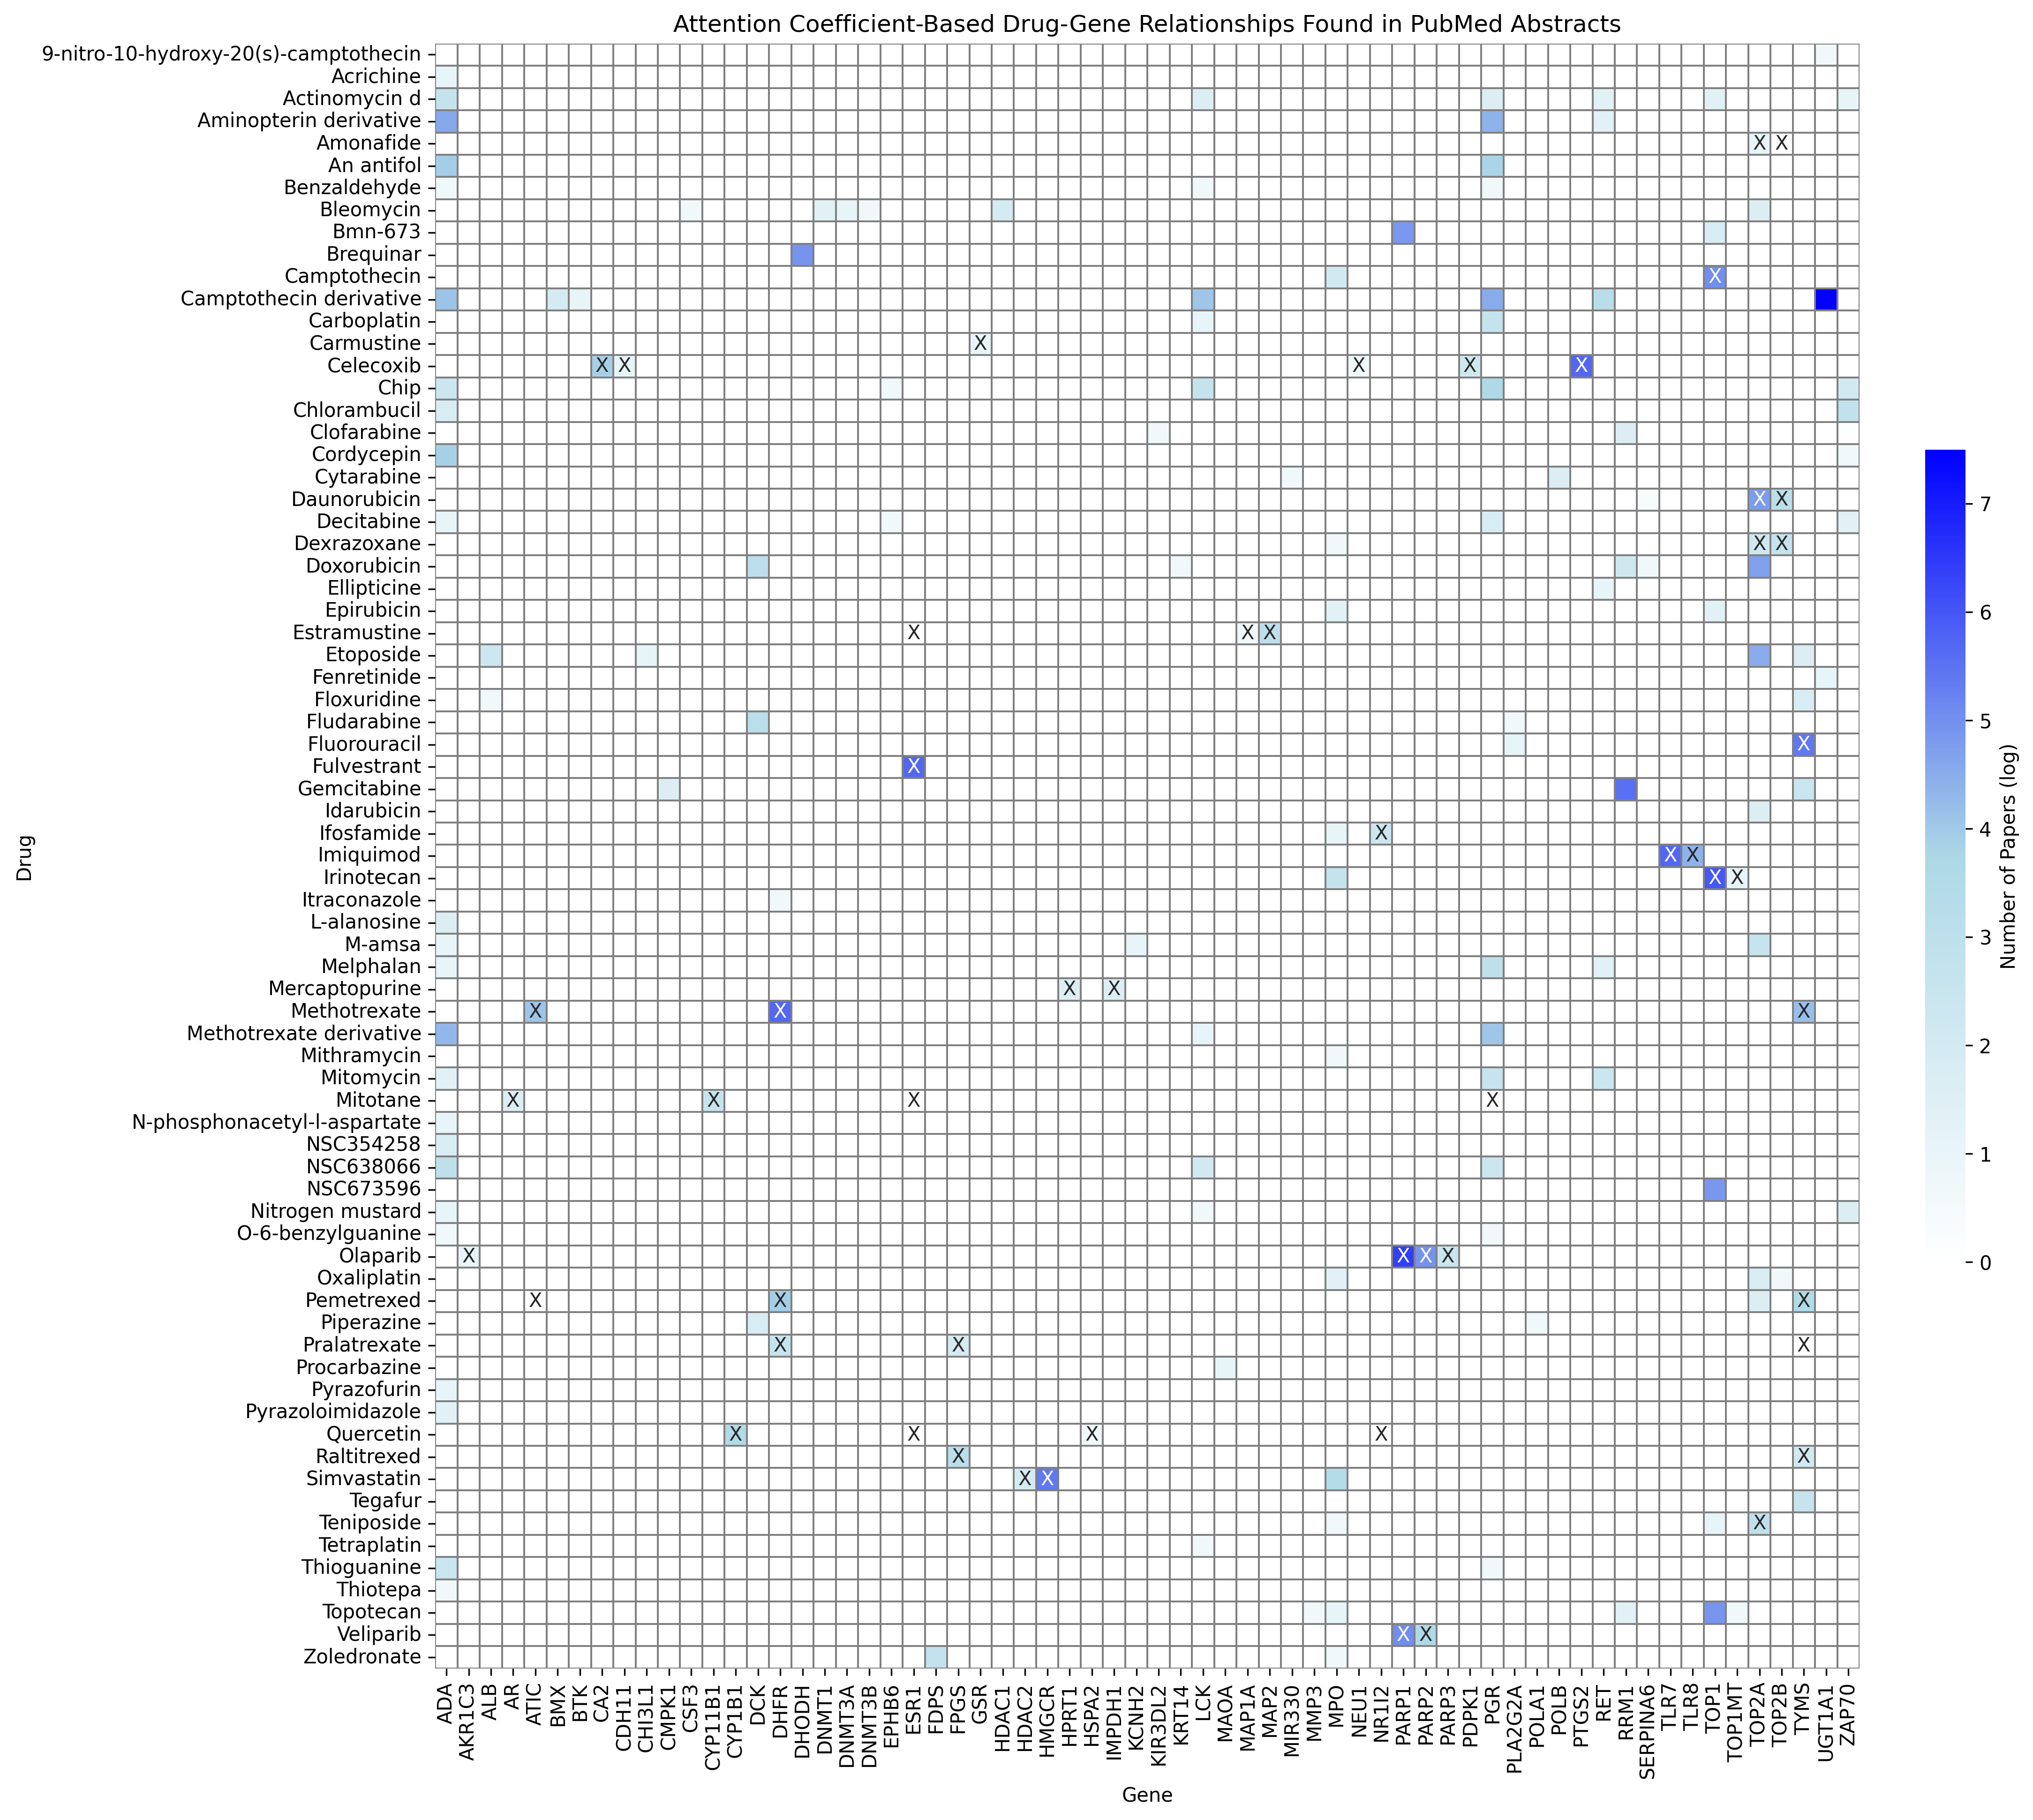

In [473]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

bubble_data = df.groupby(['drug', 'gene'])['num'].sum().reset_index()
bubble_data = bubble_data.sort_values('gene')

pivot_table_data = bubble_data.pivot_table(values='num', index='drug', columns='gene', aggfunc='sum').fillna(0)
pivot_table_data.index = list(pivot_table_data.index)
pivot_table_data.columns = list(pivot_table_data.columns)
pivot_table_data = pivot_table_data.loc[bubble_data['drug'].unique()]
pivot_table_data = pivot_table_data.sort_index()
pivot_table_data.index = pivot_table_data.index.str.capitalize()
pivot_table_data = pivot_table_data.groupby(pivot_table_data.index).mean()

pivot_table_data.columns = [i.replace('adenosine deaminase', 'ADA') for i in pivot_table_data.columns]
# pivot_table_data = pivot_table_data.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]
pivot_table_data = pivot_table_data.loc[pivot_table_data.sum(axis=1) != 0]
# pivot_table_data = pivot_table_data.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]
pivot_table_data.index = pivot_table_data.index \
                                        .str.replace('2-n-methyl-6-thiaellipticinum iodide', 'NSC638066') \
                                        .str.replace('7-ethyl-10-hydroxycamptothecin', 'NSC673596') \
                                        .str.replace('6-mercaptopurine', 'Mercaptopurine') \
                                        .str.replace('6-thioguanine', 'Thioguanine') \
                                        .str.replace('8-chloro-adenosine', 'NSC354258') \
                                        .str.replace('Benzaldehyde (ben)', 'Benzaldehyde') 
pivot_table_data = pivot_table_data.loc[sorted(pivot_table_data.index), sorted(pivot_table_data.columns)]

t = pivot_table_data.copy()
t = t*0
tmp = dti.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]


k = np.sign(tmp.groupby(tmp.index).sum())
t.loc[tmp.index, tmp.columns] = k

log_scale_data = np.log1p(pivot_table_data[(t.sum(axis=1) != 0) | (pivot_table_data.sum(axis=1) != 0)])

tmp = t[(t.sum(axis=1) != 0) | (pivot_table_data.sum(axis=1) != 0)]


annot_data = np.where(tmp==1, "X", "")

# Creating Heatmap without annotations (numbers)
plt.figure(figsize=(30, 15), dpi=300)

cmap = LinearSegmentedColormap.from_list(
    'Custom cmap', ['#ffffff', 'lightblue', 'blue'], N=256)

# heatmap を描画
ax = sns.heatmap(
    log_scale_data, annot=annot_data,  fmt="",  cmap=cmap, square=True,
    linewidths=.5,
    cbar_kws={'label': 'Number of Papers (log)', 'shrink': 0.5, 'pad': 0.02},
    linecolor='gray'
)

ax.set_yticks(np.arange(len(log_scale_data.index)) + 0.5)  # 目盛りの位置を中央に設定
ax.set_yticklabels(log_scale_data.index) 

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Drug')
plt.title('Attention Coefficient-Based Drug-Gene Relationships Found in PubMed Abstracts')
plt.show()

# For poster

In [581]:
np.sum(np.sign(pivot_table_data).sum(axis=1) > 2)

24

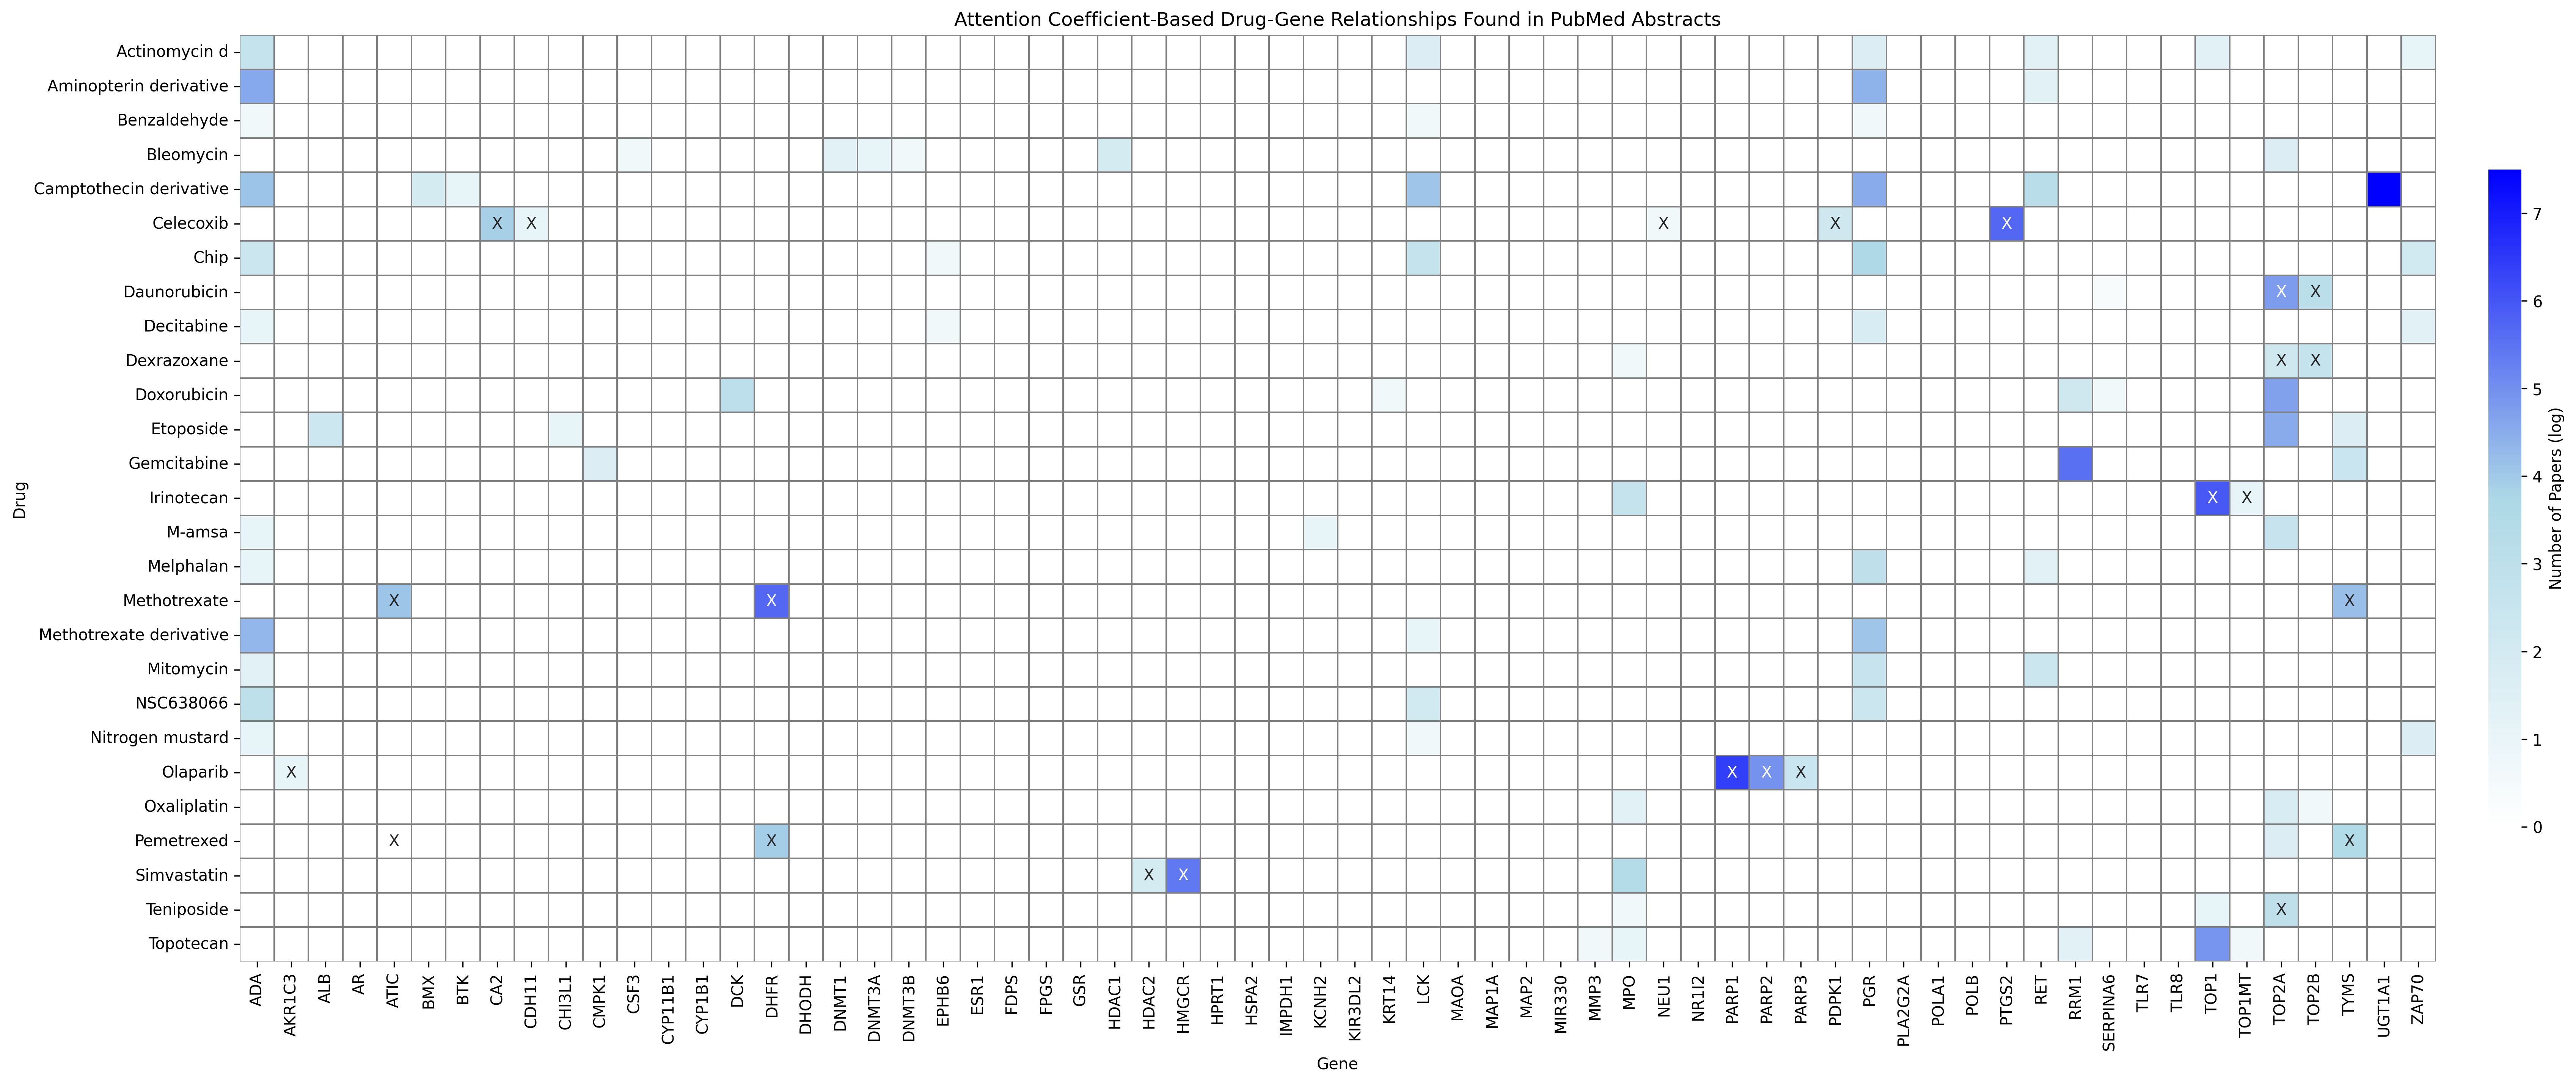

In [582]:
bubble_data = df.groupby(['drug', 'gene'])['num'].sum().reset_index()
bubble_data = bubble_data.sort_values('gene')

pivot_table_data = bubble_data.pivot_table(values='num', index='drug', columns='gene', aggfunc='sum').fillna(0)
pivot_table_data.index = list(pivot_table_data.index)
pivot_table_data.columns = list(pivot_table_data.columns)
pivot_table_data = pivot_table_data.loc[bubble_data['drug'].unique()]
pivot_table_data = pivot_table_data.sort_index()
pivot_table_data.index = pivot_table_data.index.str.capitalize()
pivot_table_data = pivot_table_data.groupby(pivot_table_data.index).mean()

# Small visualzation
pivot_table_data = pivot_table_data[np.sign(pivot_table_data).sum(axis=1) > 2]

pivot_table_data.columns = [i.replace('adenosine deaminase', 'ADA') for i in pivot_table_data.columns]
# pivot_table_data = pivot_table_data.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]
pivot_table_data = pivot_table_data.loc[pivot_table_data.sum(axis=1) != 0]
# pivot_table_data = pivot_table_data.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]
pivot_table_data.index = pivot_table_data.index \
                                        .str.replace('2-n-methyl-6-thiaellipticinum iodide', 'NSC638066') \
                                        .str.replace('7-ethyl-10-hydroxycamptothecin', 'NSC673596') \
                                        .str.replace('6-mercaptopurine', 'Mercaptopurine') \
                                        .str.replace('6-thioguanine', 'Thioguanine') \
                                        .str.replace('8-chloro-adenosine', 'NSC354258') \
                                        .str.replace('Benzaldehyde (ben)', 'Benzaldehyde') 
pivot_table_data = pivot_table_data.loc[sorted(pivot_table_data.index), sorted(pivot_table_data.columns)]

t = pivot_table_data.copy()
t = t*0
tmp = dti.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]


k = np.sign(tmp.groupby(tmp.index).sum())
t.loc[tmp.index, tmp.columns] = k

log_scale_data = np.log1p(pivot_table_data[(t.sum(axis=1) != 0) | (pivot_table_data.sum(axis=1) != 0)])

tmp = t[(t.sum(axis=1) != 0) | (pivot_table_data.sum(axis=1) != 0)]


annot_data = np.where(tmp==1, "X", "")

# Creating Heatmap without annotations (numbers)
plt.figure(figsize=(30, 15), dpi=300)

cmap = LinearSegmentedColormap.from_list(
    'Custom cmap', ['#ffffff', 'lightblue', 'blue'], N=256)

# heatmap を描画
ax = sns.heatmap(
    log_scale_data, annot=annot_data,  fmt="",  cmap=cmap, square=True,
    linewidths=.5,
    cbar_kws={'label': 'Number of Papers (log)', 'shrink': 0.5, 'pad': 0.02},
    linecolor='gray'
)

ax.set_yticks(np.arange(len(log_scale_data.index)) + 0.5)  # 目盛りの位置を中央に設定
ax.set_yticklabels(log_scale_data.index) 

plt.xticks(rotation=90)
plt.xlabel('Gene')
plt.ylabel('Drug')
plt.title('Attention Coefficient-Based Drug-Gene Relationships Found in PubMed Abstracts')
plt.show()

In [324]:
tmp.index[tmp.index.str.contains('can')]

Index(['Irinotecan', 'Topotecan'], dtype='object')

In [325]:
tmp.index[tmp.index.str.contains('cin')]

Index(['2-n-methyl-6-thiaellipticinum iodide', 'Bleomycin', 'Camptothecin',
       'Daunorubicin', 'Doxorubicin', 'Epirubicin', 'Idarubicin',
       'Mithramycin', 'Mitomycin'],
      dtype='object')

In [313]:
drug = 'Camptothecin'
pivot_table_data.loc[drug][pivot_table_data.loc[drug] != 0]

MPO       7.0
TOP1    300.0
Name: Camptothecin, dtype: float64

In [314]:
drug = 'Topotecan'
pivot_table_data.loc[drug][pivot_table_data.loc[drug] != 0]

MMP3        1.0
MPO         2.0
RRM1        3.0
TOP1      134.0
TOP1MT      1.0
Name: Topotecan, dtype: float64

In [315]:
drug = 'Irinotecan'
pivot_table_data.loc[drug][pivot_table_data.loc[drug] != 0]

MPO        13.0
TOP1      381.0
TOP1MT      3.0
Name: Irinotecan, dtype: float64

In [318]:
drug = 'Doxorubicin'
pivot_table_data.loc[drug][pivot_table_data.loc[drug] != 0]

DCK          20.0
KIR3DL2       1.0
KRT14         1.0
RRM1          8.0
SERPINA6      1.0
TOP2A       107.0
Name: Doxorubicin, dtype: float64

In [319]:
drug = 'Daunorubicin'
pivot_table_data.loc[drug][pivot_table_data.loc[drug] != 0]

HBG2          0.5
SERPINA6      0.5
TOP2A       120.0
TOP2B        31.5
Name: Daunorubicin, dtype: float64

In [216]:
drug = 'Doxorubicin'
pivot_table_data.loc[drug][pivot_table_data.loc[drug] != 0]

DCK          20.0
KIR3DL2       1.0
KRT14         1.0
RRM1          8.0
SERPINA6      1.0
TOP2A       107.0
Name: Doxorubicin, dtype: float64

In [321]:
pivot_table_data.to_csv('pubchem.csv')

In [169]:
np.sum((pivot_table_data.values))

8843.0